In [1]:
import trackpy as tp 
import pims
import glob
import numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import bmc
from tqdm import trange

## Onion 2

In [2]:
path = "../data/onion_2/Onion_bulk_20x/*.bmp"
nfiles = len(glob.glob(path))

# um_per_px for each zoom
x10 = 9.51/13
x20 = 9.51/24
x40 = 9.51/57
fps = 30
#frames = pims.as_grey(pims.open(path))

Frame 357: 16 trajectories present.


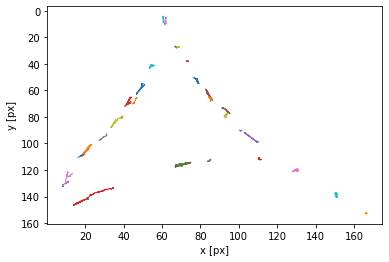

In [3]:
f = bmc.annotate(path, show=False, diameter=11, minmass=150, crop=((0,26), (27,0)))
t = bmc.get_trajectories(f, show=True, diameter=11, minmass=150, search_range=10, clip_stubs=50)

In [4]:
all_v, x_v, y_v = bmc.particle_velocity(t, 0, x20, 30)

Text(0.5, 1.0, 'velocity histogram')

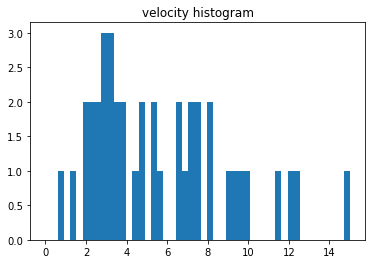

In [5]:
plt.figure()
_ = plt.hist(all_v, bins=np.linspace(0, 15))
plt.title("velocity histogram")

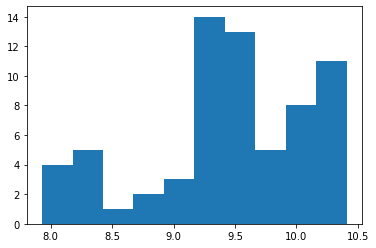

In [6]:
plt.figure()
_ = plt.hist(bmc.viscosity(t, 1, x20, 30))

In [7]:
t[t["frame"]==0]["particle"].values

array([ 0,  1,  2,  4,  6,  7, 11, 13, 14, 15, 16, 19, 21])

In [ ]:
all_visc = np.array([])
for i in trange(np.max(t["frame"].values)+1):
    indices = t[t["frame"]==i]["particle"].values
    for j in range(len(indices)):
        all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, indices[j], x20, 30)))

In [ ]:
plt.figure()
_ = plt.hist(all_visc, bins=np.linspace(0, 12), log=False)

## Onion 4

Frame 249: 19 trajectories present.


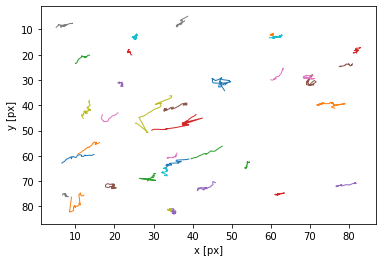

../data/onion_4/Onion_bulk_20x-11


In [10]:
i = 19
folder_paths = glob.glob("../data/onion_4/*")
path = folder_paths[i] + "/*bmp"

f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
t = bmc.get_trajectories(f, show=True, diameter=11, minmass=10, search_range=6, clip_stubs=25)
print(folder_paths[i])

In [11]:
lengths = []
for folder in folder_paths:
    files = glob.glob(folder + "/*bmp")
    lengths.append(len(files))

In [12]:
def all_viscosity(t):
    all_visc = np.array([])
    for i in np.unique(t["particle"]):
        all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, i, x20, fps)))
    return all_visc

def all_velocity(t):
    all_vel = np.array([])
    for i in np.unique(t["particle"]):
        all_vel = np.append(all_vel, np.mean(bmc.particle_velocity(t, i, x20, fps)[0]))
    return all_vel

In [13]:
all_velocities = np.array([])
all_viscosities= np.array([])
for folder in folder_paths:
    path = folder + "/*bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    all_velocities = np.append(all_velocities, all_velocity(t))
    all_viscosities= np.append(all_viscosities, all_viscosity(t))

Frame 246: 13 trajectories present.


In [15]:
len(np.unique(all_velocities)), len(np.unique(all_viscosities))

(905, 905)

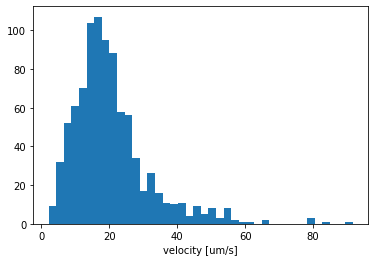

In [16]:
plt.figure()
cnts,_,_ = plt.hist(all_velocities, bins=40, log=0)#, bins=np.linspace(0,13))
plt.xlabel("velocity [um/s]");

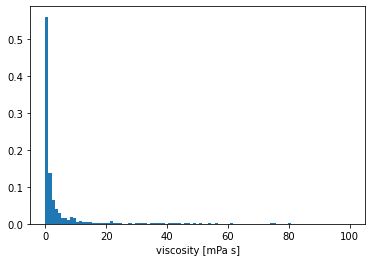

In [29]:
plt.figure()
cnts,_,_ = plt.hist(all_viscosities, bins=np.linspace(0,100, 100), density=1)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");

In [ ]:
np.unique(t["particle"])